###Mount drive to import datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import math
import time

import numpy as np
from numpy import array
import tensorflow as tf 
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split
import requests

In [3]:
import gensim
import time

from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

##Functions

In [4]:
import json

def write_list(a_list, file_name="names.json"):
    print("Started writing list data into a json file")
    with open(file_name, "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")

# Read list to memory
def read_list(file_name="names.json"):
    # for reading also binary mode is important
    with open(file_name, 'rb') as fp:
        n_list = json.load(fp)
        return n_list


In [5]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
plt.style.use('ggplot')

def plot_history(history, compl=""): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy' + compl)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss' + compl)
    plt.legend()

In [8]:
def train_network(model, data, save_as='best weights.h5', compl=""):
  x_train, x_test, y_train, y_test = data
  
  # add checkpoint to save the network and stop if training doesn't improve MCTI
  checkpoint = keras.callbacks.ModelCheckpoint(save_as, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

  model.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy', f1_m, precision_m, recall_m])

  # Fiting  the model
  history = model.fit(x_train, y_train, epochs=100, 
                        callbacks=checkpoint, verbose=2, 
                        validation_data=(x_test, y_test), 
                        batch_size=128)

  # Evaluate the model
  [modelloss, modelaccuracy, 
  modelf1, modelprecision, 
  modelrecall] = model.evaluate(x_test, y_test, verbose=0)

  plot_history(history, compl)

  return modelaccuracy


## Dataset

In [9]:
url= 'https://github.com/chap0lin/PPF-MCTI/blob/master/Datasets/oportunidadesrotulo%20-%20%C3%9Altima.xlsx?raw=true'
myfile = requests.get(url)
# dataMCTI = pd.read_excel(myfile.content, sheet_name='oportunidadesrotulo')
dataMCTI = pd.read_excel(myfile.content)


print("MCTI Dataset has " + str(dataMCTI.shape[0]) + " examples with " + str(dataMCTI.shape[1]) + " columns of information")

MCTI Dataset has 928 examples with 21 columns of information


In [10]:
labels = dataMCTI['opo_brazil']
labelsMCTI = np.where(labels == "Y", 1, 0)

In [11]:
sentencesMCTIList_xp8 = read_list("/content/drive/MyDrive/Mestrado/xp8_list.json")

##WORD2VEC MODEL##

In [12]:
#initialise callback class
class callback(CallbackAny2Vec):
  """
  Print the loss value after each epoch
  """
  def __init__(self):
    self.epoch = 0
    #gensim loss is cumulative, so we record previous values to print
    self.loss_previous_step = 0 

  def on_epoch_end(self, model):
    loss = model.get_latest_training_loss()
    if self.epoch % 100 == 0:
      print('Loss after epoch {}: {}'.format(self.epoch, loss-self.loss_previous_step))

    self.epoch+= 1
    self.loss_previous_step = loss

In [ ]:
#initialise word2vec class
w2v_model = Word2Vec(size=300,
                     window = 15,
                     min_count = 1,
                     workers = 20,
                     sg = 1,
                     negative = 5,
                     sample = 1e-5)

#build vocab
w2v_model.build_vocab(sentencesMCTIList_xp8) 

#train the model
start = time.time()
w2v_model.train(sentencesMCTIList_xp8,
                total_examples=w2v_model.corpus_count,
                epochs = 1001,
                report_delay = 1,
                compute_loss = True,
                callbacks=[callback()])
end = time.time()

print("elapsed time in seconds: "+str(end-start))
w2v_model.save('/content/drive/MyDrive/Mestrado/word2vec_xp8.model')

###Load model###

In [13]:
reloaded_w2v_model = Word2Vec.load('/content/drive/MyDrive/Mestrado/word2vec_xp8.model')
words = list(reloaded_w2v_model.wv.vocab)

print('Vocab size: '+str(len(words)))

Vocab size: 16075


In [21]:
x_vals, y_vals, labels = reduce_dimensions(reloaded_w2v_model)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


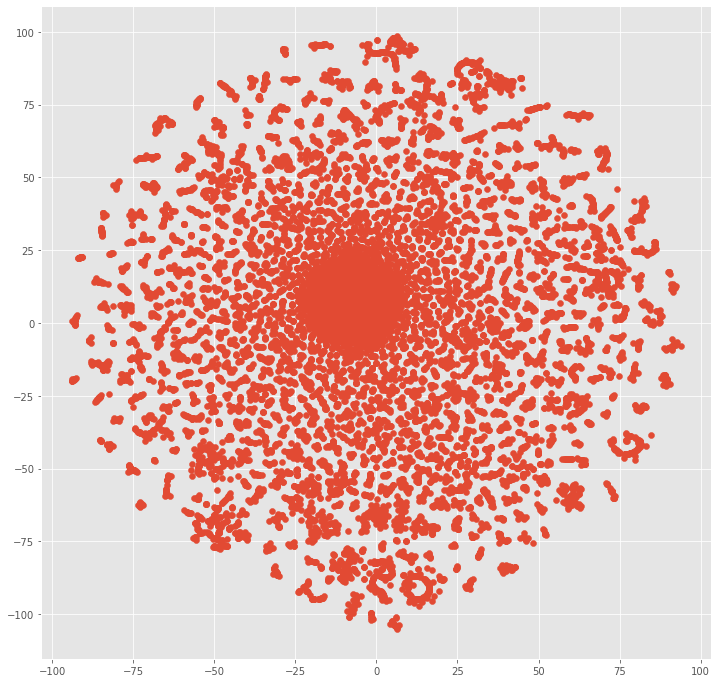

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

##Training the network##

In [14]:
mapped_words = []
for word in words:
  mapped_words.append(reloaded_w2v_model.wv[word])

In [15]:
# create training testing data

MCTIinput_vector = []
for sentence in sentencesMCTIList_xp8:
  aux_vector = []
  for word in sentence:
    aux_vector.append(reloaded_w2v_model.wv[word])
  MCTIinput_vector.append(aux_vector)

sentences_lengths = []
for sentence in sentencesMCTIList_xp8:
  sentences_lengths.append(len(sentence))

print(np.shape(MCTIinput_vector))

max_sizeMCTI = 0
for sentence in MCTIinput_vector:
  if len(sentence) > max_sizeMCTI:
    max_sizeMCTI = len(sentence)
  

lengthMCTI = max_sizeMCTI
MCTIinput_vector = pad_sequences(MCTIinput_vector, maxlen=lengthMCTI, padding='pre')


#MCTI
x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI = train_test_split(MCTIinput_vector, 
                                                                    labelsMCTI, 
                                                                    test_size=0.20, 
                                                                    random_state=20)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(928,)


In [16]:
learning_data = (x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI)

In [17]:
path = "/content/drive/MyDrive/Mestrado/PesosXp8/"

###LSTM###

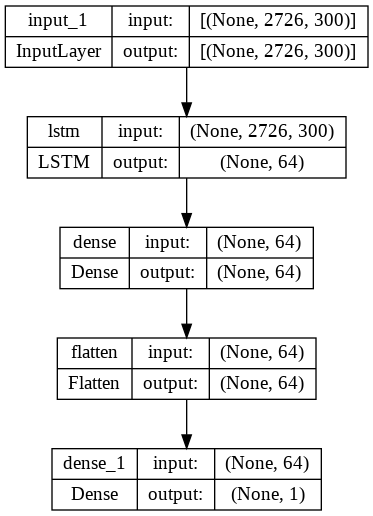

In [27]:
mcti_LSTM_Model = Sequential()
mcti_LSTM_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_LSTM_Model.add(LSTM(64))
mcti_LSTM_Model.add(Dense(64, activation='relu'))
mcti_LSTM_Model.add(Flatten())
mcti_LSTM_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_LSTM_Model, show_shapes=True)

STARTING TRAINING #0
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.73656, saving model to /content/drive/MyDrive/Mestrado/PesosXp8/best weights LSTM 0.h5
6/6 - 11s - loss: 0.6795 - accuracy: 0.6375 - f1_m: 0.4902 - precision_m: 0.6246 - recall_m: 0.4991 - val_loss: 0.6582 - val_accuracy: 0.7366 - val_f1_m: 0.4941 - val_precision_m: 0.8500 - val_recall_m: 0.3491 - 11s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.73656
6/6 - 3s - loss: 0.6372 - accuracy: 0.7574 - f1_m: 0.5469 - precision_m: 0.9518 - recall_m: 0.3857 - val_loss: 0.6110 - val_accuracy: 0.7312 - val_f1_m: 0.4389 - val_precision_m: 1.0000 - val_recall_m: 0.2836 - 3s/epoch - 442ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.73656
6/6 - 2s - loss: 0.5735 - accuracy: 0.7480 - f1_m: 0.5039 - precision_m: 0.9861 - recall_m: 0.3442 - val_loss: 0.5398 - val_accuracy: 0.7204 - val_f1_m: 0.3963 - val_precision_m: 1.0000 - val_recall_m: 0.2509 - 2s/epoch - 359ms/step
Epoch 4

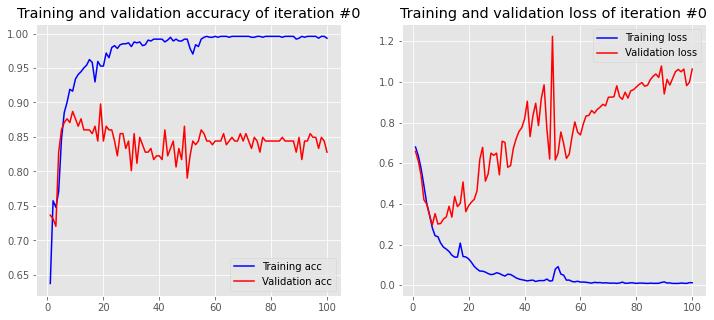

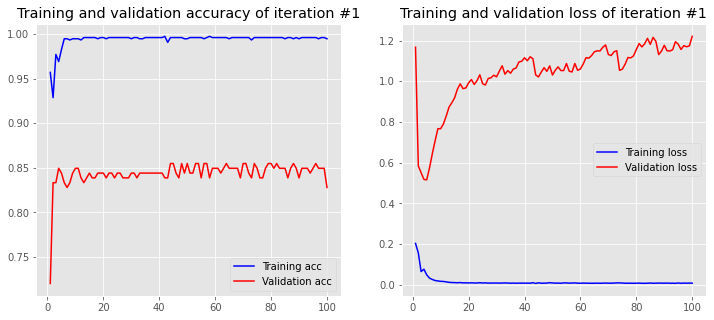

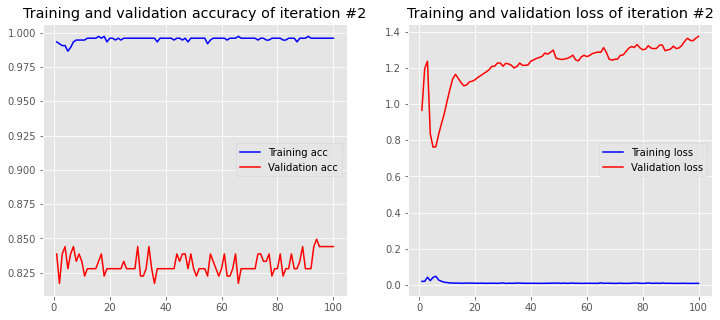

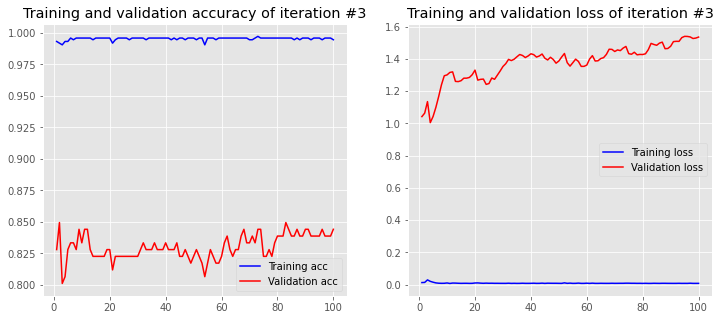

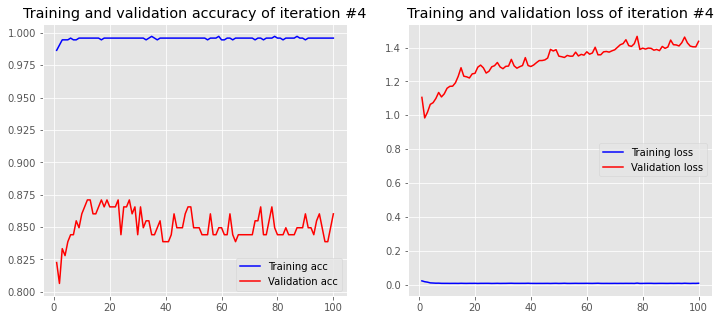

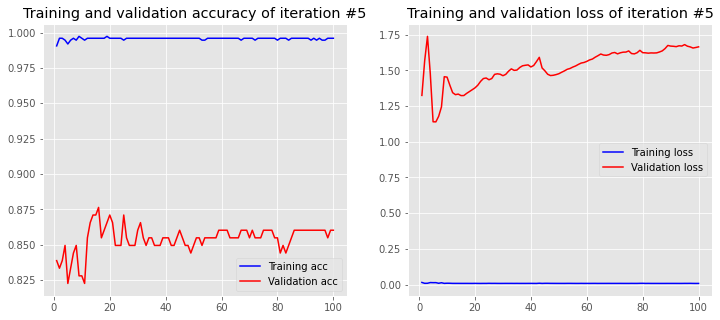

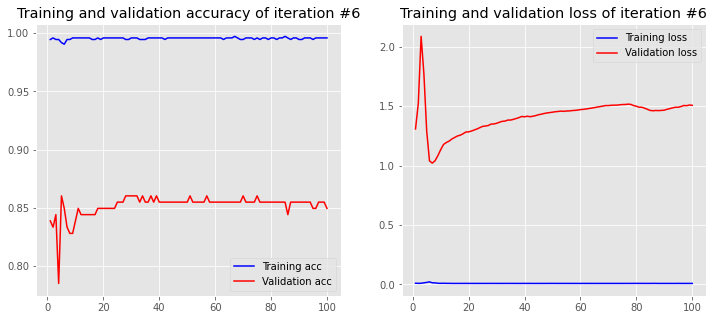

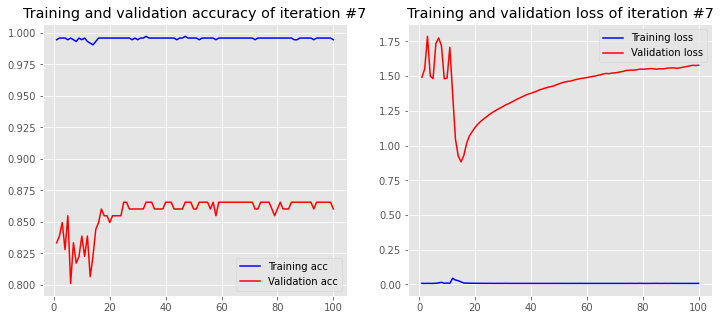

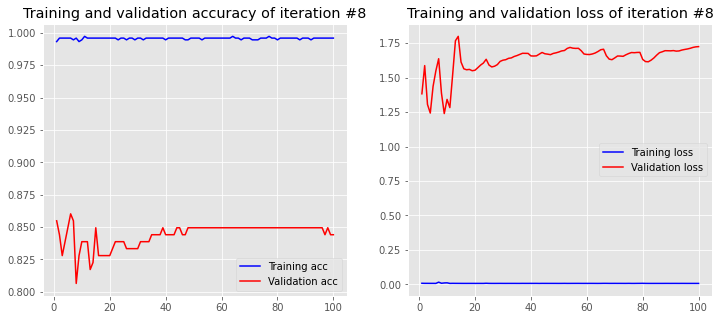

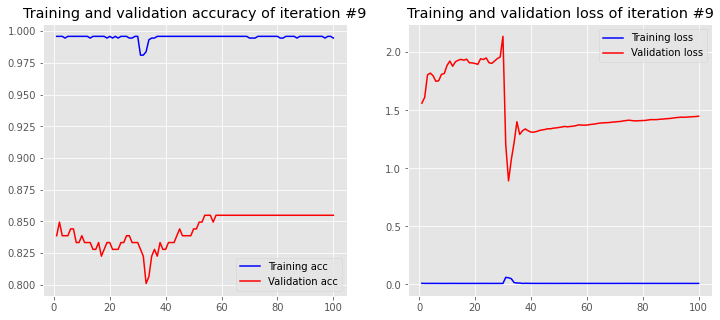

In [28]:
i = 0
best_i = 0
best_acc = 0
history = []
while i < 10:
  print("STARTING TRAINING #" + str(i))
  current_acc = train_network(mcti_LSTM_Model, learning_data, 
                              path + "best weights LSTM " + str(i) + ".h5",
                              compl = " of iteration #" + str(i))
  if current_acc > best_acc:
    best_acc = current_acc
    best_i = i
  i+=1


print("Best LSTM Accuracy: " + str(best_acc))
print(best_i)

In [30]:
reconstructed_model_LSTM = keras.models.load_model(path + "best weights LSTM " + str(0) + ".h5", 
                                                   custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_LSTM.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 89.784944
f1_score: 85.067540
precision: 97.095960
recall: 75.905579


###CNN###

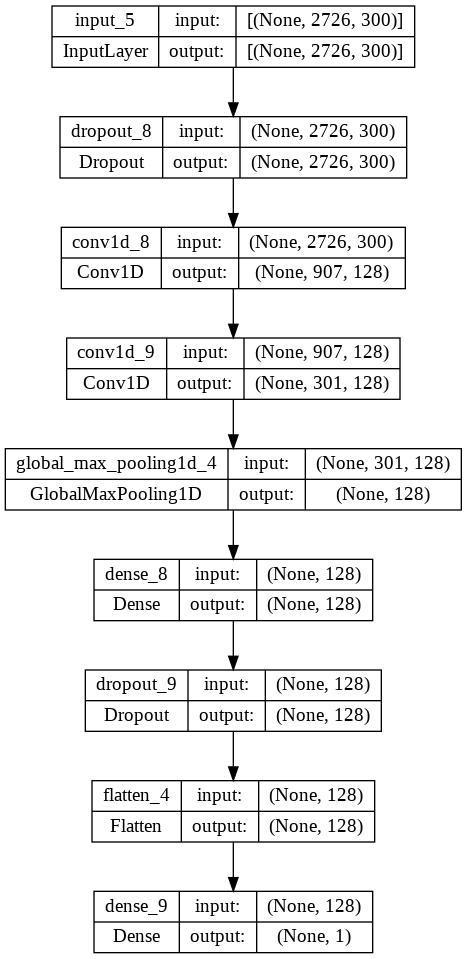

In [26]:
mcti_CNN_Model = Sequential()
mcti_CNN_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_CNN_Model.add(Dropout(0.5))

# Conv1D + global max pooling
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
mcti_CNN_Model.add(Dense(128, activation="relu"))
mcti_CNN_Model.add(Dropout(0.5))

mcti_CNN_Model.add(Flatten())
mcti_CNN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_CNN_Model, show_shapes=True)

STARTING TRAINING #0
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.62366, saving model to /content/drive/MyDrive/Mestrado/PesosXp8/best weights CNN 0.h5
6/6 - 4s - loss: 0.6860 - accuracy: 0.5741 - f1_m: 0.0904 - precision_m: 0.1667 - recall_m: 0.1375 - val_loss: 0.6557 - val_accuracy: 0.6237 - val_f1_m: 0.0385 - val_precision_m: 0.5000 - val_recall_m: 0.0200 - 4s/epoch - 672ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.62366 to 0.70968, saving model to /content/drive/MyDrive/Mestrado/PesosXp8/best weights CNN 0.h5
6/6 - 2s - loss: 0.6453 - accuracy: 0.6523 - f1_m: 0.1899 - precision_m: 0.8333 - recall_m: 0.1096 - val_loss: 0.6299 - val_accuracy: 0.7097 - val_f1_m: 0.3508 - val_precision_m: 1.0000 - val_recall_m: 0.2182 - 2s/epoch - 309ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.70968 to 0.71505, saving model to /content/drive/MyDrive/Mestrado/PesosXp8/best weights CNN 0.h5
6/6 - 2s - loss: 0.5928 - accuracy: 0.7129 - f1_m: 0.3976 - precision_m:

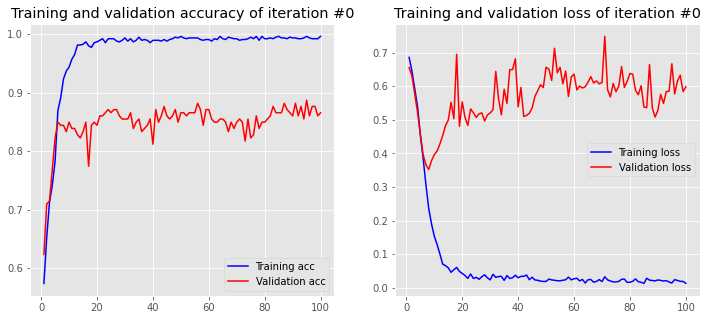

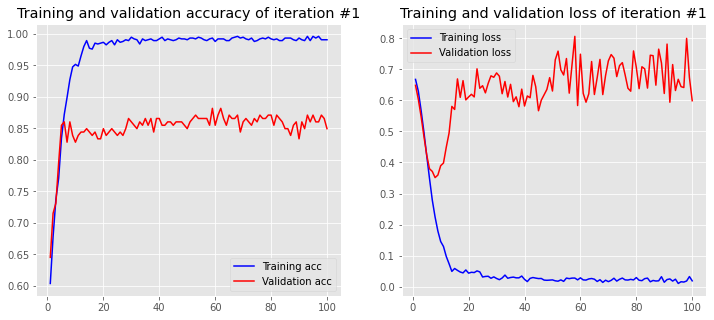

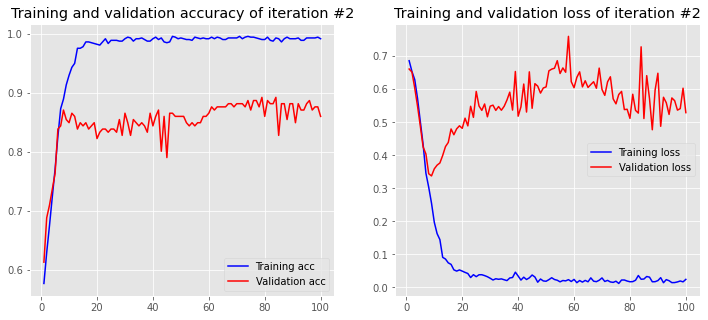

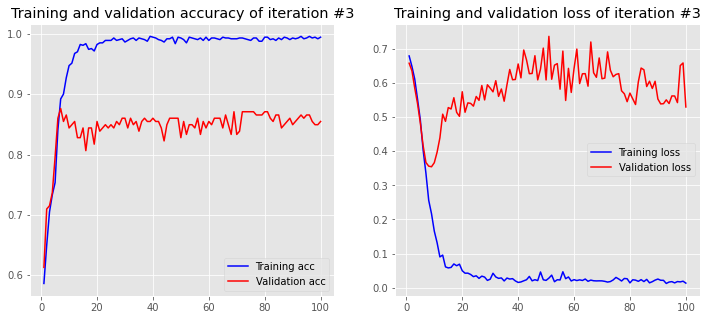

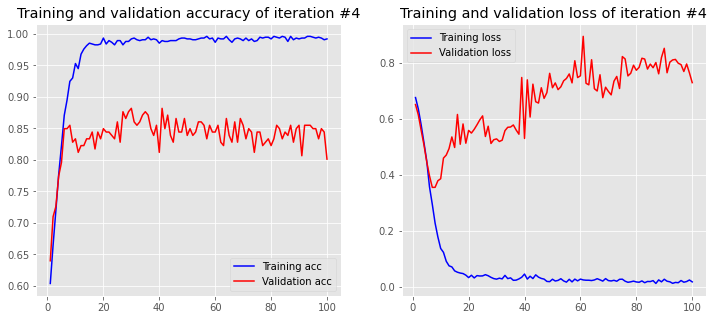

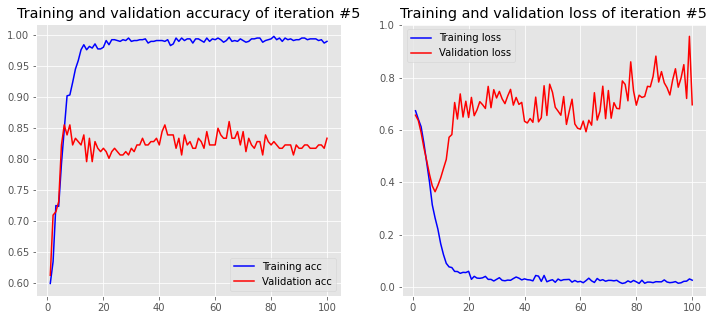

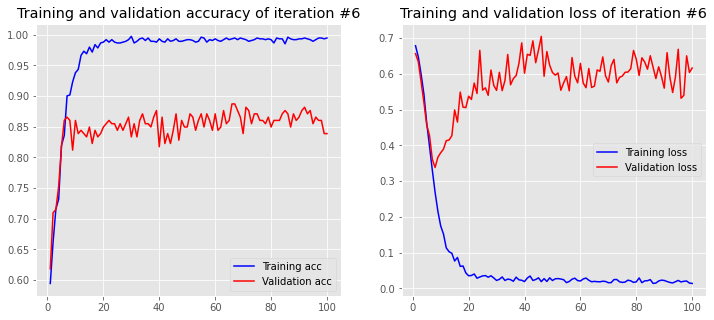

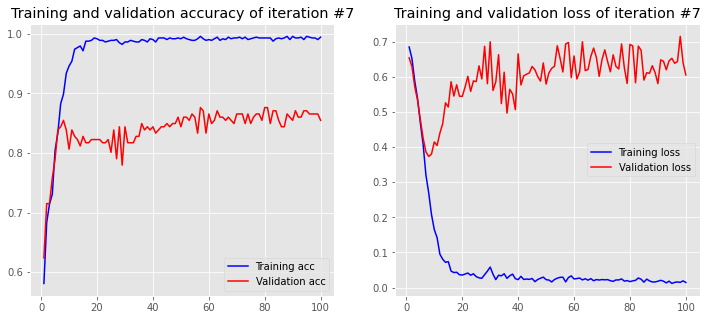

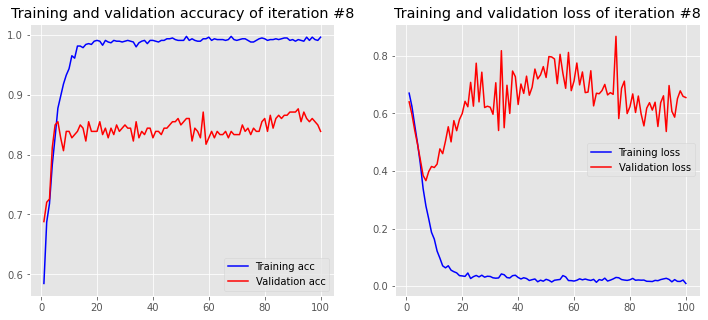

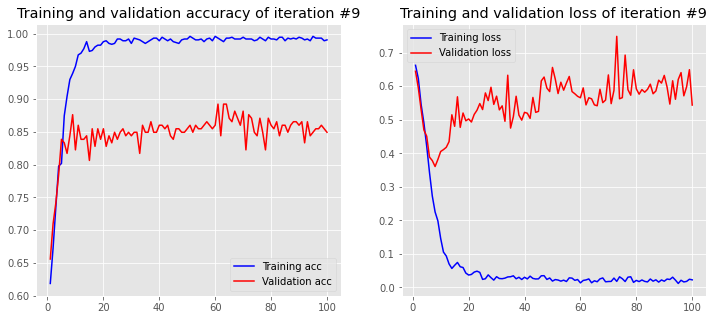

In [29]:
i = 0
best_i = 0
best_acc = 0
while i < 10:
  print("STARTING TRAINING #" + str(i))
  mcti_CNN_Model = Sequential()
  mcti_CNN_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
  mcti_CNN_Model.add(Dropout(0.5))

  # Conv1D + global max pooling
  mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
  mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
  mcti_CNN_Model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer:
  mcti_CNN_Model.add(Dense(128, activation="relu"))
  mcti_CNN_Model.add(Dropout(0.5))

  mcti_CNN_Model.add(Flatten())
  mcti_CNN_Model.add(Dense(1, activation='sigmoid'))
  current_acc = train_network(mcti_CNN_Model, learning_data, 
                              path + "best weights CNN " + str(i) + ".h5",
                              compl = " of iteration #" + str(i))
  if current_acc > best_acc:
    best_acc = current_acc
    best_i = i
  i+=1
print("Best CNN Accuracy: " + str(best_acc))
print(best_i)

In [ ]:
reconstructed_model = keras.models.load_model(path + "best weights CNN " + str(best_i) + ".h5", 
                                              custom_objects={'f1_m':f1_m, 
                                                              "precision_m":precision_m, 
                                                              "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 92.473119
f1_score: 88.419127
precision: 98.717946
recall: 80.850625


###DNN###

In [ ]:
mcti_DNN_Model = Sequential()
mcti_DNN_Model.add(Dense(512, input_shape=np.shape(MCTIinput_vector[0])))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(256))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(128))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Flatten())
mcti_DNN_Model.add(Dense(1, activation='sigmoid'))

#keras.utils.plot_model(mcti_DNN_Model, show_shapes=True)

STARTING TRAINING #0
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.79032, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights DNN 0.h5
6/6 - 3s - loss: 0.6331 - accuracy: 0.6307 - f1_m: 0.2940 - precision_m: 0.4760 - recall_m: 0.2787 - val_loss: 0.5523 - val_accuracy: 0.7903 - val_f1_m: 0.6237 - val_precision_m: 0.9643 - val_recall_m: 0.4645 - 3s/epoch - 537ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.79032 to 0.79570, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights DNN 0.h5
6/6 - 2s - loss: 0.4711 - accuracy: 0.8235 - f1_m: 0.7301 - precision_m: 0.8602 - recall_m: 0.6449 - val_loss: 0.4679 - val_accuracy: 0.7957 - val_f1_m: 0.6724 - val_precision_m: 0.8750 - val_recall_m: 0.5500 - 2s/epoch - 341ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.79570 to 0.82258, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights DNN 0.h5
6/6 - 2s - loss: 0.3408 - accuracy: 0.8571 - f1_m: 0.7930 - precision_m:

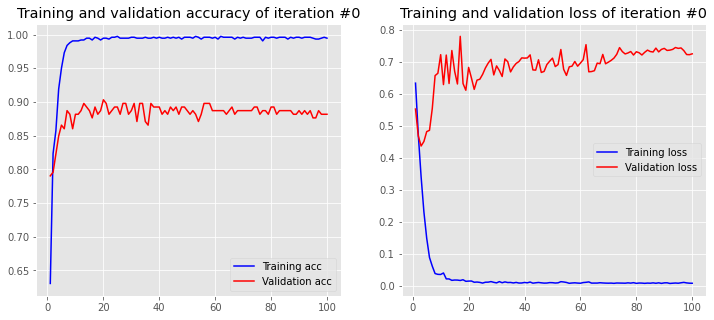

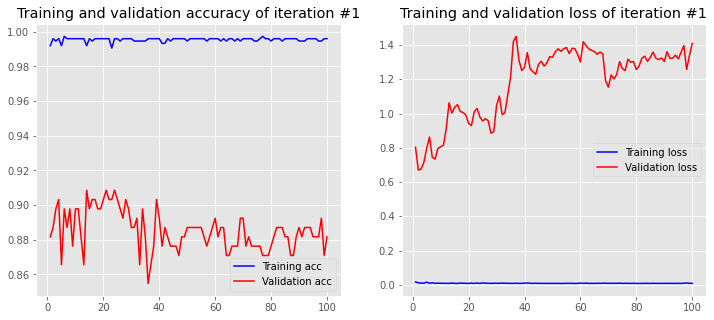

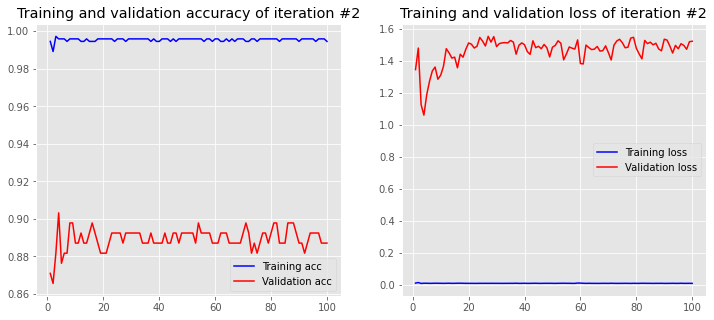

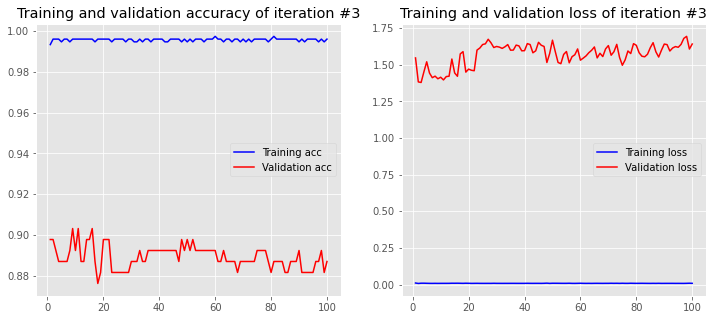

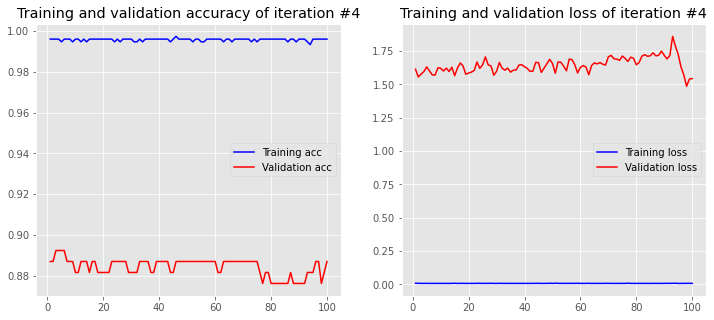

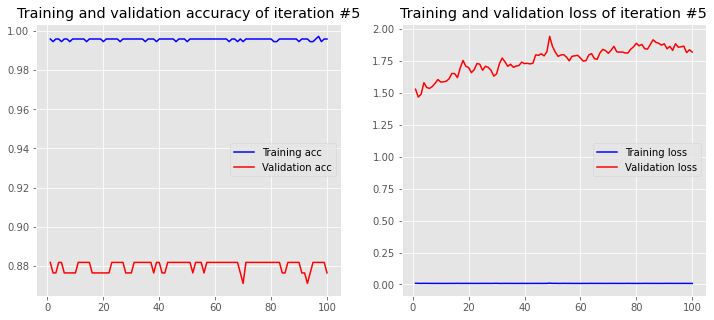

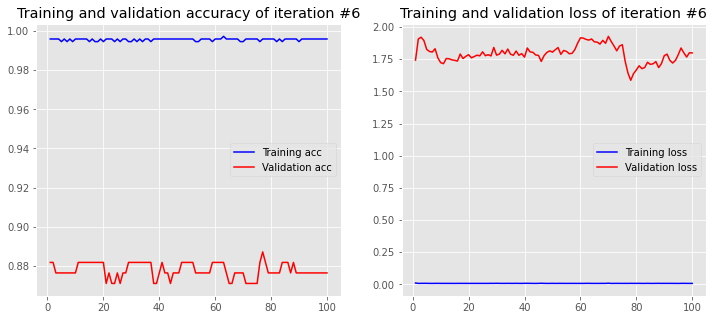

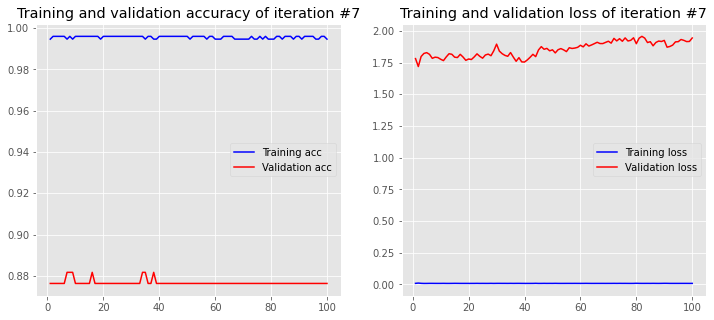

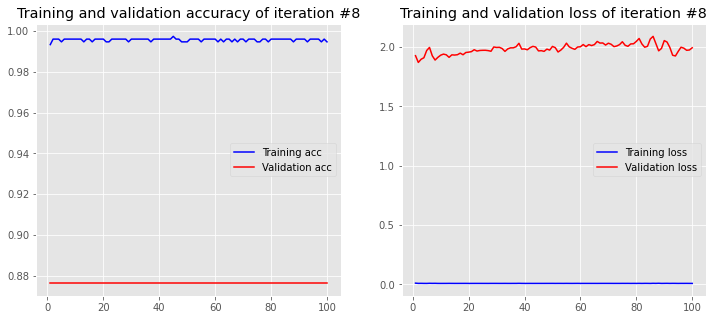

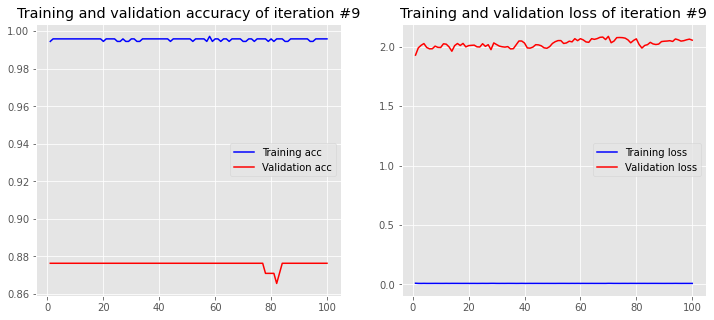

In [ ]:
i = 0
best_i = 0
best_acc = 0
test_data = []
while i < 10:
  print("STARTING TRAINING #" + str(i))
  current_acc = train_network(mcti_DNN_Model, learning_data, 
                              path + "best weights DNN " + str(i) + ".h5",
                              compl = " of iteration #" + str(i))
  if current_acc > best_acc:
    best_acc = current_acc
    best_i = i
  i+=1


print("Best DNN Accuracy: " + str(best_acc))
print(best_i)

In [ ]:
reconstructed_model = keras.models.load_model(path + "best weights DNN " + str(best_i) + ".h5",
                                              custom_objects={'f1_m':f1_m, 
                                                              "precision_m":precision_m, 
                                                              "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 90.322578
f1_score: 86.522371
precision: 88.696486
recall: 85.175008


###NN###

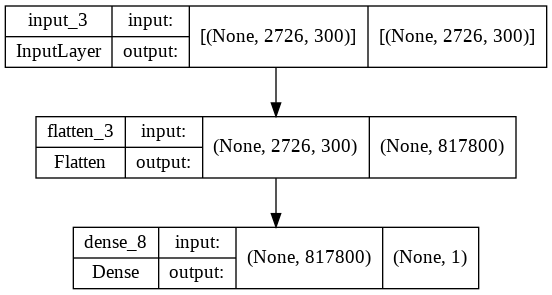

In [ ]:
mcti_NN_Model = Sequential()
mcti_NN_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_NN_Model.add(Flatten())
mcti_NN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_NN_Model, show_shapes=True)

STARTING TRAINING #0
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.77419, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights NN 0.h5
6/6 - 2s - loss: 0.6422 - accuracy: 0.6873 - f1_m: 0.5234 - precision_m: 0.7187 - recall_m: 0.4384 - val_loss: 0.5776 - val_accuracy: 0.7742 - val_f1_m: 0.6087 - val_precision_m: 1.0000 - val_recall_m: 0.4400 - 2s/epoch - 400ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.77419 to 0.81720, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights NN 0.h5
6/6 - 1s - loss: 0.3872 - accuracy: 0.9798 - f1_m: 0.9724 - precision_m: 1.0000 - recall_m: 0.9470 - val_loss: 0.5253 - val_accuracy: 0.8172 - val_f1_m: 0.6935 - val_precision_m: 0.9615 - val_recall_m: 0.5427 - 1s/epoch - 234ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.81720 to 0.83871, saving model to /content/drive/MyDrive/Mestrado/PesosXP8/best weights NN 0.h5
6/6 - 1s - loss: 0.2860 - accuracy: 0.9960 - f1_m: 0.9947 - precision_m: 1.

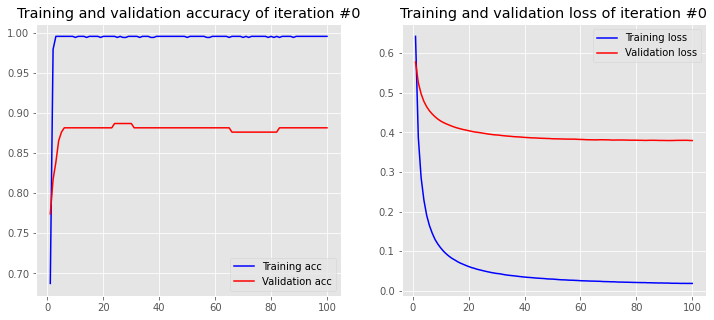

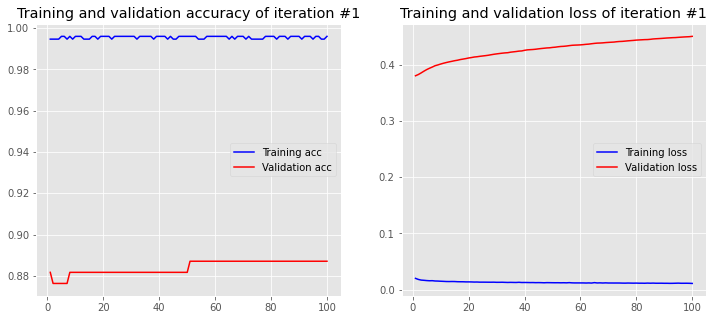

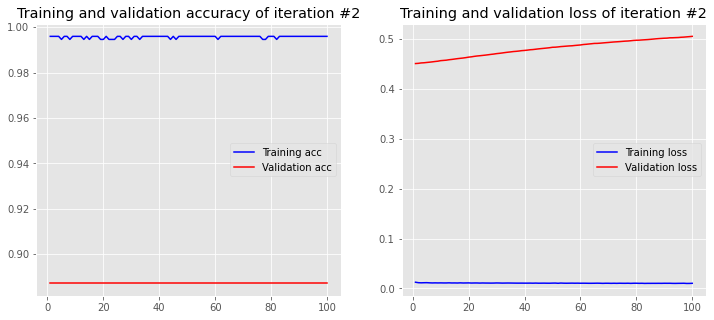

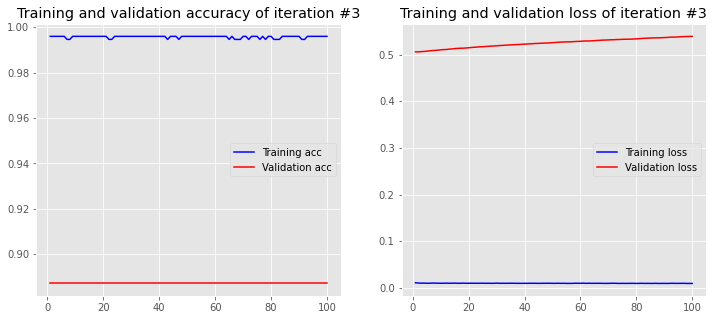

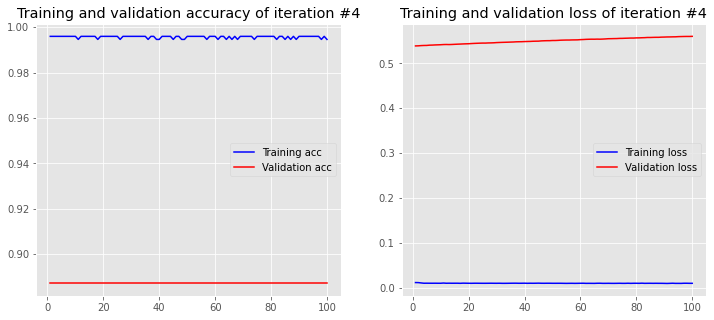

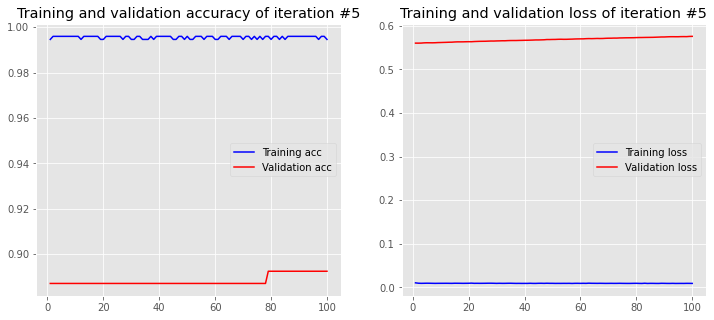

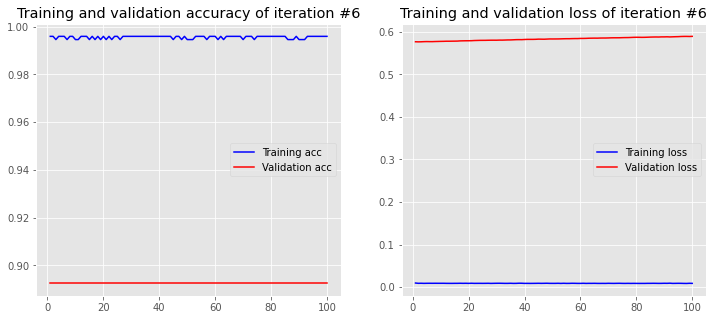

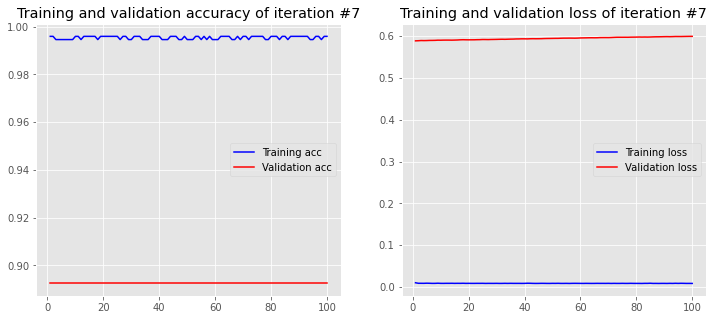

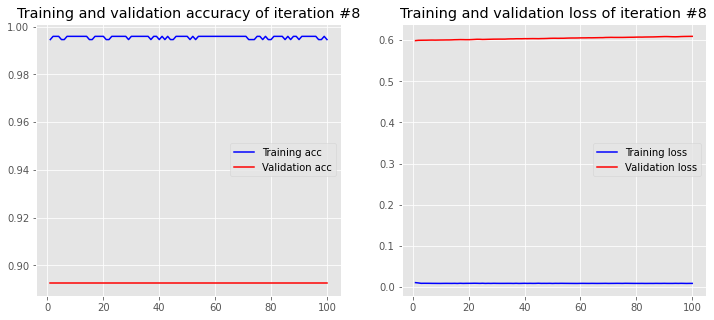

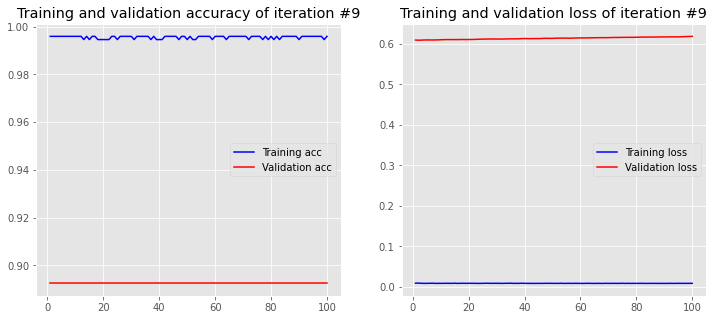

In [ ]:
i = 0
best_i = 0
best_acc = 0
test_data = []
while i < 10:
  print("STARTING TRAINING #" + str(i))
  current_acc = train_network(mcti_NN_Model, learning_data, 
                              path + "best weights NN " + str(i) + ".h5",
                              compl = " of iteration #" + str(i))
  if current_acc > best_acc:
    best_acc = current_acc
    best_i = i
  i+=1
print("Best NN Accuracy: " + str(best_acc))
print(best_i)

In [ ]:
reconstructed_model_NN = keras.models.load_model(path + "best weights NN " + str(best_i) + ".h5",
                                                 custom_objects={'f1_m':f1_m, 
                                                                 "precision_m":precision_m, 
                                                                 "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_NN.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 89.247310
f1_score: 83.824784
precision: 97.095960
recall: 74.145293
